# Perceval Quest
#### Author: *Valentin Deumier*

Our goal is to start by creating a 'classical' neural network and train it on the famous MNIST handwritten digits dataset, and then try to upgrade it by using Linear Optical Quantum Computing, in hope to increase the accuracy of the model and lower the duration of training.

### <u>2: A hybrid model</u>

In [27]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import perceval as pcvl
import perceval.components as comp
from perceval.rendering.circuit import SymbSkin, PhysSkin
from perceval import Circuit

# Parameters
IMG_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 30

In [28]:
# Data into numpy arrays
def load_data(filename):

    data = pd.read_csv(filename)
    X = np.array(data['image'].str.split(',', expand=True).values)

    # Remove the [ ] from the image data (fastest method I found)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] = X[i, j].replace('[', '').replace(']', '')
    X = X.astype(float)

    y = data['label'].values

    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)/255.0      # Reshape and normalize
    y = to_categorical(y, NUM_CLASSES)
    return X, y

# Get the absolute path to the data folder
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, 'data')

# Load the data
train_file = os.path.join(data_dir, 'train.csv')
X_train, y_train = load_data(train_file)
val_file = os.path.join(data_dir, 'val.csv')
X_val, y_val = load_data(val_file)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6000, 28, 28, 1) (6000, 10) (600, 28, 28, 1) (600, 10)


The idea here is to encode the image data into quantum data while preserving the 2-dimensional structure of the image. \
\
Like in the CNN model, we want neighbours pixels to remain close to each in the quantum representation so that we can perform "local" transformation (the equivalent of convoluting the image with a kernel), so the representation as to be continuous along both axis.\
This means that we can't flatten the data, so we can't use basis, angle or amplitude embedding.\
\
An idea could be to encode the image in a matrix representation of a unitary transformation (that could also be parametrized, and have its parameters be optimized).\
\
Being inspired by the solution of Schrodinger's equation for a time-independant Hamiltonian, we are going to represent the image $\mathbf{x}$ as the resulting evolution operator :

$$ U_t(\mathbf{x}) = \exp(-iH_{\mathbf{x}}t) $$

Where $H_{\mathbf{x}}$ is the symetric part of our image matrix:

$$ H_{\mathbf{x}} = \frac{\mathbf{x} + \mathbf{x}^T}{2} $$

with $t \in \mathbb{R}$ a parameter that we can tweak.

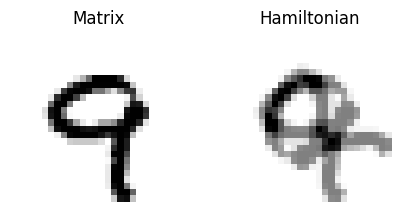

In [29]:
def toHamiltonian(x):
    H = 0.5*(x[:, :, 0] + x[:, :, 0].T)
    return H

def plot_hamiltonian(x):
    L = [x, toHamiltonian(x)]
    labels = ['Matrix', 'Hamiltonian']
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i in range(2):
        axes[i].imshow(L[i], cmap='gray_r')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Plot the first image and its Hamiltonian
plot_hamiltonian(X_train[1])

In [30]:
# As an example, we are computing the operator associated with the second image

def U(x: np.ndarray, t: float) -> np.ndarray:
    """Compute the unitary operator associated with the Hamiltonian x and time t"""
    H = toHamiltonian(x)
    return linalg.expm(-1j*H*t)

M = pcvl.Matrix(U(X_train[1], 1000))
c1 = comp.Unitary(U=M)

# Decompose the unitary into a circuit
# ub = pcvl.Circuit(2, name="ub") // comp.BS() // (0, comp.PS(phi=pcvl.Parameter("φ_a"))) // comp.BS() // (1, comp.PS(phi=pcvl.Parameter("φ_b")))
# c2 = pcvl.Circuit.decomposition(M, ub, shape=pcvl.InterferometerShape.TRIANGLE)

To reproduce the local effect of the convolution, the next layer will be constituted of a brickwork layout of beam splitters that are acting on modes close to each other.\
\
The operator associated with this layer will be denoted $V(\mathbf{\omega})$, with $\mathbf{\omega}$ being the array of parameters of the beam splitters.

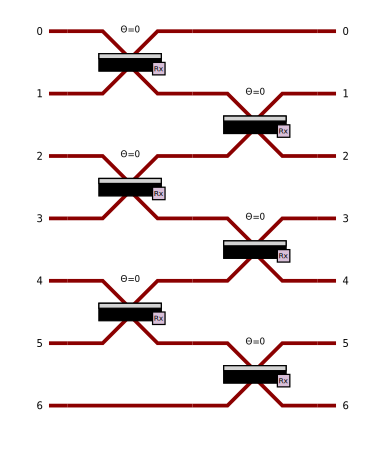

In [32]:
def brickwork(
    omega: np.ndarray,
    num_modes: int,
) -> Circuit:
    """
    Create a brickwork circuit with BS components.
    Args:   
        omega         : BS parameters (len(omega) = num_modes - 1)
        num_modes : Width of circuit
    Returns:
        Circuit
    """
    circ = Circuit(num_modes)
    even_modes = np.arange(0, num_modes - 1, 2)
    odd_modes = np.arange(1, num_modes - 1, 2)

    for k in even_modes:
        circ.add(int(k), comp.BS(omega[int(k)]))
    for j in odd_modes:
        circ.add(int(j), comp.BS(omega[int(j)]))
   
    return circ

# Example of a V(omega) layer
omega = np.zeros(6)
c2 = brickwork(omega, 7)
pcvl.pdisplay(c2)